
Predict Lipophilicity Property Using GCN
=====================

앞선 실습에서는 SMILES와 CNN 아키텍쳐를 활용한 lipophilicity 예측을 연습해보았습니다. 
이번 시간에는 분자를 Graph로 표현하여 각 원자의 벡터와 원자 간의 연결 상태를 input으로 다룰 수 있는 GCN을 구현해 봅시다.

## 1. Dataset과 DataLoader 준비하기  

Graph 형태로 데이터를 준비하기 위해서는 임의 분자의 `SMILES` 문자열이 들어왔을 때 이를 `Rdkit` 분자 오브젝트로 바꾸고 각 원자들의 node feature vector와 adjacency matrix를 만들 필요가 있습니다. 이후에는 custom dataset을 만들어 노드 벡터들이 담긴 X, 연결 상태가 담긴 A, Lipophilicity 값 y를 반환해주면 됩니다.  


### 1.1 데이터 준비하기
앞선 예제에서 사용했던 것처럼 `Lipophilicity.csv`를 다운 받은 후 train, val, test로 분할해줍니다.  
GCN의 경우 문자열의 vocabulary set을 만드는 대신 사용할 원자들의 집합을 직접 정하는 방식으로 대체합니다. 

In [186]:
!wget -q "http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/Lipophilicity.csv" -O Lipophilicity.csv

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from rdkit import Chem


def get_splitted_lipo_dataset(ratios=[0.8, 0.1, 0.1], seed=123):

    raw_data = pd.read_csv('Lipophilicity.csv') # Open original dataset
    smiles = raw_data['smiles']
        
    train_val, test = train_test_split(raw_data, test_size=ratios[2], random_state=seed)
    train, val = train_test_split(train_val, test_size=ratios[1]/(ratios[0]+ratios[1]), random_state=seed)
    
    return train, val, test

In [187]:
datasets = get_splitted_lipo_dataset()
smiles = datasets[0]
print(smiles)

      CMPD_CHEMBLID   exp                                             smiles
1369   CHEMBL199237  2.70                 O=C(NCc1ccccn1)c2ccc(Oc3ccccc3)cc2
3084   CHEMBL277863  2.05  COC(=O)N1CCN([C@H](CN2CCCC2)C1)C(=O)Cc3ccc(Cl)...
2141  CHEMBL1824036 -0.51  CS(=O)(=O)c1ccc2OCC(=O)N(CCN3CCC(CC3)NCc4ccc5O...
3741    CHEMBL87266  1.35  Cc1cc(N)c2cc(NC(=O)CC(=O)Nc3ccc4nc(C)cc(N)c4c3...
2192   CHEMBL513370  2.36  COc1ccc(N(C(C(=O)NC[C@@H](C)O)c2ccccc2F)C(=O)c...
...             ...   ...                                                ...
3180   CHEMBL578061  4.06                     N(c1ccccc1)c2ccnc(Nc3ccccc3)n2
266        CHEMBL97  2.16          COc1ccc2nccc([C@H](O)C3CC4CCN3CC4C=C)c2c1
2398   CHEMBL138649  3.60                     Oc1ccc2OC(=CC(=O)c2c1)c3ccccc3
2073   CHEMBL272705  2.21            C[C@H](CO)Nc1nc(SCc2occc2)nc3NC(=O)Sc13
2480   CHEMBL177611  0.60                 Clc1ccc(cc1)C(=O)N[C@H]2CN3CCC2CC3

[3359 rows x 3 columns]


### 1.2 Mol2Graph 구현하기  

임의의 `SMILES`가 입력되었을 때 이를 분자로 바꿔봅시다. 

- 노드 행렬 X를 만들 때 원자의 종류뿐만 아니라 Degree, 붙어 있는 수소 원자의 수, Valence, 아로마틱 여부 등을 함께 넣어줌으로써 추가적인 정보를 제공합니다. 

- 인접 행렬 A를 만들 때는 `Rdkit`에서 기본적으로 계산해주는 행렬에서 대각 성분에 1을 더함으로써 이후 GCN이 이루어질 때 본인의 노드 정보도 함께 추가될 수 있도록 합니다. 

- 추가적으로 각 분자들은 임의의 원자 개수를 가지고 있으므로 미리 최대 원자 수를 설정해놓고(본 예시에서는 70개) X, A 행렬을 만들어줍니다.

In [67]:
LIST_SYMBOLS = ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
            'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
            'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
            'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']


def atom_feature(atom):
    return np.array(char_to_ix(atom.GetSymbol(), LIST_SYMBOLS) +
                    char_to_ix(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    char_to_ix(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    char_to_ix(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    char_to_ix(int(atom.GetIsAromatic()), [0, 1]))    # (40, 6, 5, 6, 2)


def char_to_ix(x, allowable_set):
    if x not in allowable_set:
        return [0] # Unknown Atom Token
    return [allowable_set.index(x)+1]


def mol2graph(smi, MAX_LEN):
    mol = Chem.MolFromSmiles(smi)

    X = np.zeros((MAX_LEN, 5), dtype=np.uint8)
    A = np.zeros((MAX_LEN, MAX_LEN), dtype=np.uint8)

    temp_A = Chem.rdmolops.GetAdjacencyMatrix(mol).astype(np.uint8, copy=False)[:MAX_LEN, :MAX_LEN]
    num_atom = temp_A.shape[0]
    A[:num_atom, :num_atom] = temp_A + np.eye(temp_A.shape[0], dtype=np.uint8)
    
    for i, atom in enumerate(mol.GetAtoms()):
        feature = atom_feature(atom)
        X[i, :] = feature
        if i + 1 >= num_atom: break
            
    return X, A

smiles = "O=C(NCc1ccccn1)c2ccc(Oc3ccccc3)cc2"
X, A = mol2graph(smiles, 70)

In [69]:
from torch.utils.data import Dataset, DataLoader

class gcnDataset(Dataset):
    def __init__(self, df, max_len=120):
        self.smiles = df["smiles"]
        self.exp = df["exp"].values
                
        list_X = list()
        list_A = list()
        for i, smiles in enumerate(self.smiles):
            X, A = mol2graph(smiles, max_len)
            list_X.append(X)
            list_A.append(A)
            
        self.X = np.array(list_X, dtype=np.uint8)
        self.A = np.array(list_A, dtype=np.uint8)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.A[index], self.exp[index]
    
sample_dataset = gcnDataset(datasets[0])

## 2. Model Construction

Vanila GCN 기반의 Lipophilicity 예측 아키텍쳐를 구현하여 봅시다. 이를 위해 크게 4가지의 Module을 구현하고 사용합니다.  

- **BN1d** X 행렬에 대해서 각 노드 피처 벡터들을 Batch Normalization할 수 있는 module입니다.  
- **GConv** X, A를 입력 받아서 인접한 노드들의 정보를 바탕으로 각 노드 벡터를 업데이트하는 module입니다.  
- **Readout** GConv를 거친 노드 벡터들로부터 invariant한 molecular vector representation을 만들기 위한 pooling module입니다.  
- **GCNNet** 노드 행렬 X를 embedding matrix로 변환한 후 `GConv` 모듈을 통과시키고 `Readout` 모듈로 molvec을 만든 후 이로부터 lipophilicity를 예측하는 module입니다. 

In [189]:
import torch
import torch.nn as nn
import torch.optim as optim


class BN1d(nn.Module):
    def __init__(self, out_dim, use_bn):
        super(BN1d, self).__init__()
        self.use_bn = use_bn
        self.bn = nn.BatchNorm1d(out_dim)
             
    def forward(self, x):
        if not self.use_bn:
            return  x
        origin_shape = x.shape
        x = x.view(-1, origin_shape[-1])
        x = self.bn(x)
        x = x.view(origin_shape)
        return x

    
class GConv(nn.Module):
    def __init__(self, input_dim, output_dim, use_bn):
        super(GConv, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = BN1d(output_dim, use_bn)
        self.relu = nn.ReLU()
        
    def forward(self, X, A):
        x = self.fc(X)
        x = torch.matmul(A, x)
        x = self.relu(self.bn(x))
        return x, A
        
    
class Readout(nn.Module):
    def __init__(self, out_dim, molvec_dim):
        super(Readout, self).__init__()
        self.readout_fc = nn.Linear(out_dim, molvec_dim)
        nn.init.xavier_normal_(self.readout_fc.weight.data)

    def forward(self, output_H):
        molvec = self.readout_fc(output_H)
        molvec = torch.mean(molvec, dim=1)
        return molvec
    

class GCNNet(nn.Module):
    
    def __init__(self, args):
        super(GCNNet, self).__init__()
        
        # Create Atom Element embedding layer
        self.embedding = self.create_emb_layer([args.vocab_size, args.degree_size,
                                                args.numH_size, args.valence_size,
                                                args.isarom_size],  args.emb_train)    
        
        self.gcn_layers = nn.ModuleList()
        for i in range(args.n_layer):
            self.gcn_layers.append(GConv(args.in_dim if i==0 else args.out_dim, args.out_dim, args.use_bn))
                                   
        self.readout = Readout(args.out_dim, args.molvec_dim)
        
        self.fc1 = nn.Linear(args.molvec_dim, args.molvec_dim//2)
        self.fc2 = nn.Linear(args.molvec_dim//2, args.molvec_dim//2)
        self.fc3 = nn.Linear(args.molvec_dim//2, 1)
        self.relu = nn.ReLU()
        
    def create_emb_layer(self, list_vocab_size, emb_train=False):
        list_emb_layer = nn.ModuleList()
        for i, vocab_size in enumerate(list_vocab_size):
            vocab_size += 1
            emb_layer = nn.Embedding(vocab_size, vocab_size)
            weight_matrix = torch.zeros((vocab_size, vocab_size))
            for i in range(vocab_size):
                weight_matrix[i][i] = 1
            emb_layer.load_state_dict({'weight': weight_matrix})
            emb_layer.weight.requires_grad = emb_train
            list_emb_layer.append(emb_layer)
        return list_emb_layer

    def _embed(self, x):
        list_embed = list()
        for i in range(5):
            list_embed.append(self.embedding[i](x[:, :, i]))
        x = torch.cat(list_embed, 2)
        return x
        
    def forward(self, x, A):
        A = A.float()
        x = self._embed(x)   
        
        for i, module in enumerate(self.gcn_layers):
            x, A = module(x, A)
        x = self.readout(x)
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.squeeze(x)
        

## 3. Train, Validation, Test

Data, Model, Loss, Optimization을 모두 같이 사용하여 봅시다. Epoch 별로 train과 validation, test가 이루어질 수 있게 함수를 나누었습니다. 이 때 `DataLoader`로부터 X, A, y를 받은 후 `model(X,A)`를 수행하여 `pred_y`를 구한다는 점이 CNN 실습과 다릅니다.


In [190]:
def train(model, dataloader, optimizer, criterion, args, **kwargs):
    
    epoch_train_loss = 0
    list_train_loss = list()
    cnt_iter = 0
    for batch_idx, batch in enumerate(dataloader):
        X, A, y = batch[0].long(), batch[1].long(), batch[2].float()
        X, A, y = X.to(args.device), A.to(args.device), y.to(args.device)
    
        model.train()
        optimizer.zero_grad()

        pred_y = model(X, A)
        
        train_loss = criterion(pred_y, y)
        epoch_train_loss += train_loss.item()
        list_train_loss.append({'epoch':batch_idx/len(dataloader)+kwargs['epoch'], 'train_loss':train_loss.item()})
        train_loss.backward()
        optimizer.step()
        
        cnt_iter += 1
    return model, list_train_loss


def validate(model, dataloader, criterion, args):
    
    epoch_val_loss = 0
    cnt_iter = 0
    for batch_idx, batch in enumerate(dataloader):
        X, A, y = batch[0].long(), batch[1].long(), batch[2].float()
        X, A, y = X.to(args.device), A.to(args.device), y.to(args.device)
    
        model.eval()
        pred_y = model(X, A)
        val_loss = criterion(pred_y, y)
        epoch_val_loss += val_loss.item()
        cnt_iter += 1

    return epoch_val_loss/cnt_iter

def test(model, dataloader, args, **kwargs):

    list_y, list_pred_y = list(), list()
    for batch_idx, batch in enumerate(dataloader):
        X, A, y = batch[0].long(), batch[1].long(), batch[2].float()
        X, A, y = X.to(args.device), A.to(args.device), y.to(args.device)
    
        model.eval()
        pred_y = model(X, A)
        list_y += y.cpu().detach().numpy().tolist()
        list_pred_y += pred_y.cpu().detach().numpy().tolist()

    mae = mean_absolute_error(list_y, list_pred_y)
    std = np.std(np.array(list_y)-np.array(list_pred_y))
    return mae, std, list_y, list_pred_y


def experiment(partition, args):
    ts = time.time()
    
    model = GCNNet(args)    
    model.to(args.device)
    criterion = nn.MSELoss()
    
    # Initialize Optimizer
    trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
    if args.optim == 'ADAM':
        optimizer = optim.Adam(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSProp':
        optimizer = optim.RMSprop(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    else:
        assert False, "Undefined Optimizer Type"
        
    # Train, Validate, Evaluate
    list_train_loss = list()
    list_val_loss = list()
    list_mae = list()
    list_std = list()
    
    args.best_mae = 10000
    for epoch in range(args.epoch):
        model, train_losses = train(model, partition['train'], optimizer, criterion, args, **{'epoch':epoch})
        val_loss = validate(model, partition['val'], criterion, args)
        mae, std, true_y, pred_y = test(model, partition['test'], args, **{'epoch':epoch})
        
        list_train_loss += train_losses
        list_val_loss.append({'epoch':epoch, 'val_loss':val_loss})
        list_mae.append({'epoch':epoch, 'mae':mae})
        list_std.append({'epoch':epoch, 'std':std})
        
        if args.best_mae > mae or epoch==0:
            args.best_epoch = epoch
            args.best_mae = mae
            args.best_std = std
            args.best_true_y = true_y
            args.best_pred_y = pred_y
            

    # End of experiments
    te = time.time()
    args.elapsed = te-ts
    args.train_losses = list_train_loss
    args.val_losses = list_val_loss
    args.maes = list_mae
    args.stds = list_std

    return model, args 

## 4. Experiment

실험을 진행해봅시다. 이때 Embedding, Model Architecture, Optimizer, Training Configuration을 설정할 필요가 있습니다.  
첫번째 실험으로 Learning Rate와 N Layer를 바꿔가면서 실험해보도록 하겠습니다.  

In [191]:
import argparse
import time 
from sklearn.metrics import mean_absolute_error
from utils import *


seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ==== Embedding Config ==== #
args.max_len = 70
args.vocab_size = 40
args.degree_size = 6
args.numH_size = 5
args.valence_size = 6
args.isarom_size = 2
args.emb_train = True


# ==== Model Architecture Config ==== #
args.in_dim = 64
args.out_dim = 256
args.molvec_dim = 512
args.n_layer = 1
args.use_bn = True
args.act = 'relu'
args.dp_rate = 0.3


# ==== Optimizer Config ==== #
args.lr = 0.00005
args.l2_coef = 0.0001
args.optim = 'ADAM'


# ==== Training Config ==== #
args.epoch = 300
args.batch_size = 256
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.exp_name = 'exp1_lr_stage'


writer = Writer(prior_keyword=['n_layer', 'use_bn', 'lr', 'dp_rate', 'emb_train', 'epoch', 'batch_size'])
writer.clear()

# Define Hyperparameter Search Space
#list_n_layer = [1]
list_lr = [0.001, 0.005]
list_n_layer = [2,3,4,5]


train_dataloader = DataLoader(gcnDataset(datasets[0], args.max_len), batch_size=args.batch_size, shuffle=True)
val_dataloader = DataLoader(gcnDataset(datasets[1], args.max_len), batch_size=args.batch_size, shuffle=False)
test_dataloader = DataLoader(gcnDataset(datasets[2], args.max_len), batch_size=args.batch_size, shuffle=False)
partition = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

cnt_exp = 0
for lr in list_lr:
    for n_layer in list_n_layer:
        args.lr = lr
        args.n_layer = n_layer

        model, result = experiment(partition, args)
        writer.write(result)
        
        cnt_exp += 1
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f} sec'.format(cnt_exp, result.best_mae, result.best_std, result.best_epoch, result.elapsed))

[Exp  1] got mae: 0.485, std: 0.691 at epoch 270 took 117.41767930984497 sec
[Exp  2] got mae: 0.468, std: 0.680 at epoch 258 took 146.95619344711304 sec
[Exp  3] got mae: 0.455, std: 0.656 at epoch 296 took 169.77326846122742 sec
[Exp  4] got mae: 0.436, std: 0.642 at epoch 282 took 196.60933375358582 sec
[Exp  5] got mae: 0.508, std: 0.712 at epoch 278 took 116.0598316192627 sec
[Exp  6] got mae: 0.469, std: 0.689 at epoch 213 took 144.84185910224915 sec
[Exp  7] got mae: 0.469, std: 0.680 at epoch 281 took 169.2616229057312 sec
[Exp  8] got mae: 0.546, std: 0.773 at epoch 298 took 199.6068012714386 sec


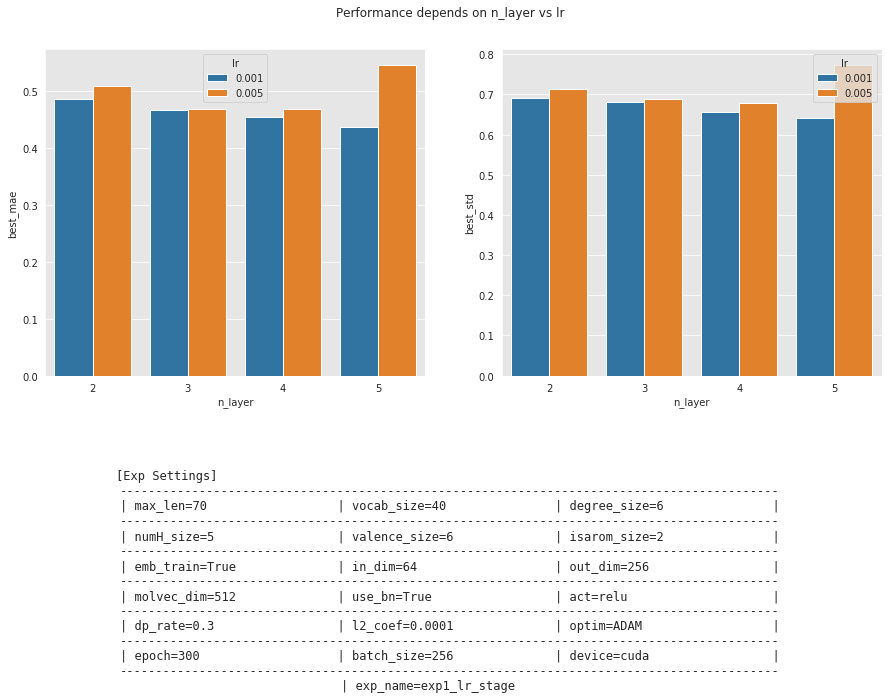

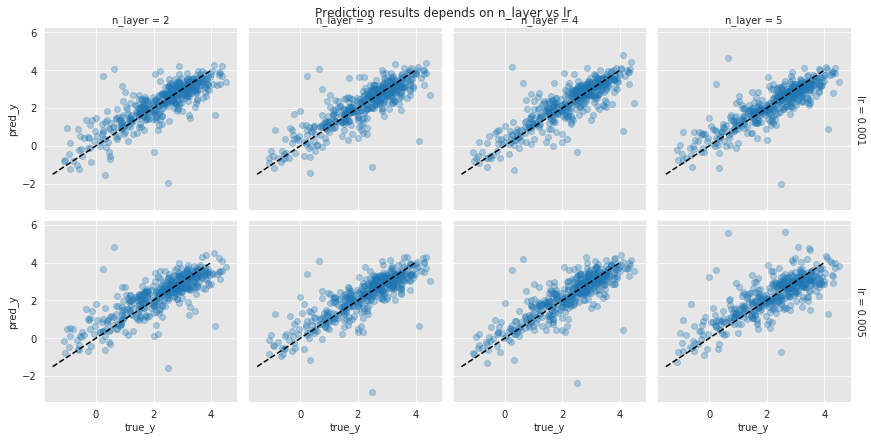

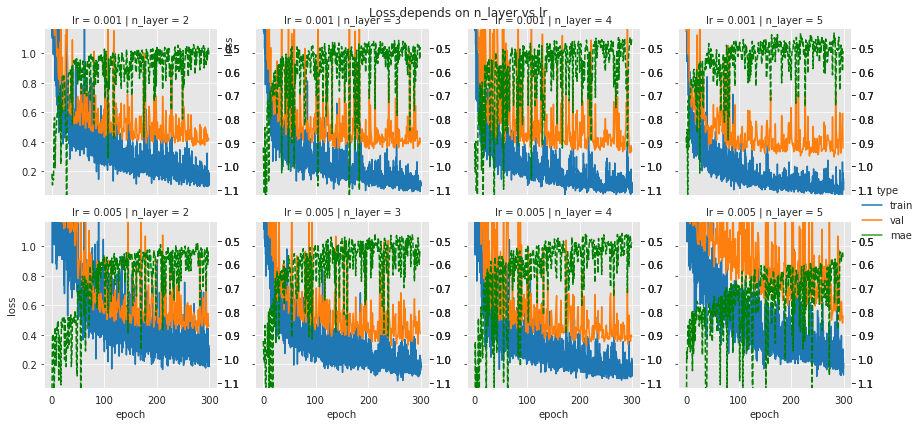

In [192]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import FontProperties
import seaborn as sns

results = writer.read(exp_name='exp1_lr_stage')
variable1 = 'n_layer'
variable2 = 'lr'


plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp1_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Prediction {} vs {}'.format(variable1, variable2))

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Loss {} vs {}'.format(variable1, variable2))

plt.show()

### 4.1 Visualizing Embedding Matrix  

`args.emb_train=True`로 하게 되면 one-hot-encoding된 임베딩 weight의 값들도 Loss를 최소화하는 방향으로 학습될 수 있습니다. 실제로 학습된 모델의 embedding matrix를 시각화하여 값이 변화했는지 확인해봅시다.

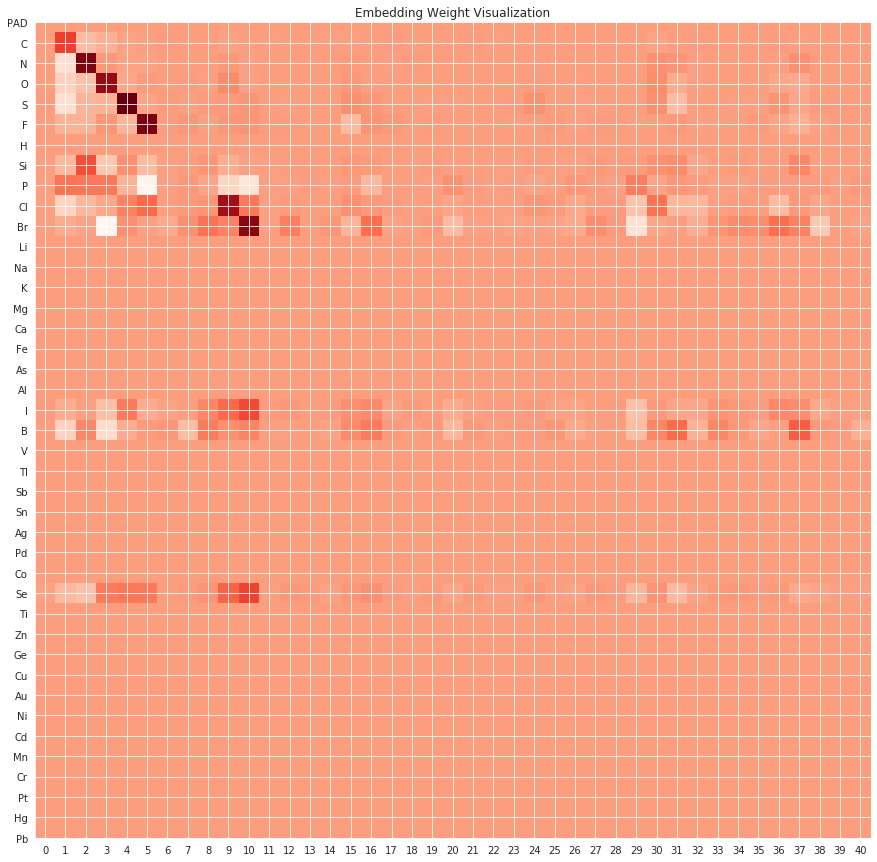

In [224]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(model.embedding[0].weight.detach().cpu().numpy(), interpolation='nearest', cmap=plt.cm.Reds)
ax.set_yticks(np.arange(len(LIST_SYMBOLS)+1))
ax.set_xticks(np.arange(len(LIST_SYMBOLS)+1))

ax.set_yticklabels(['PAD'] + LIST_SYMBOLS)
ax.set_title("Embedding Weight Visualization")
plt.show()